In [1]:
import sys
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
import pydicom
import json
import numpy as np
import gc

In [2]:
# Load the Excel file with the metadata of the LIDC-IDRI dataset
valid_series_ids = pd.read_excel(os.path.join(os.getcwd(), "LIDC-IDRI", "manifest-1743272998332", "TCIA_LIDC-IDRI_20200921-nbia-digest.xlsx"))

# Filter the valid series IDs to only include the Modality = CT
valid_series_ids = valid_series_ids[valid_series_ids["Modality"] == "CT"]["Series Instance UID"].tolist()

In [3]:
"""
    Get the paths to the DICOM folders in the LIDC-IDRI dataset.
    :param basePath: The base path to the LIDC-IDRI dataset.
    :return: A list of paths to the DICOM folders.
"""
def get_dicom_folders_LIDC(basePath: str) -> dict:
    dicom_folders = os.listdir(basePath)

    if "LICENSE" in dicom_folders:
        dicom_folders.remove("LICENSE")

    scan_paths = dict()

    # Go through the base paths to find any scans within the TCIA file and add these into the scan paths dictionary
    for dicom_folder in dicom_folders:
        folder_path = os.path.join(basePath, dicom_folder)
        if not os.path.isdir(folder_path):
            continue

        for study in os.listdir(folder_path):
            study_path = os.path.join(folder_path, study)
            if not os.path.isdir(study_path):
                continue

            for series in os.listdir(study_path):
                series_path = os.path.join(study_path, series)
                if not os.path.isdir(series_path):
                    continue

                try:
                    # Extract the series uid from the first dicom file in each end path
                    sample_file = next(f for f in os.listdir(series_path) if f.lower().endswith(".dcm"))
                    dicom_data = pydicom.dcmread(os.path.join(series_path, sample_file), stop_before_pixels=True)
                    series_uid = dicom_data.SeriesInstanceUID

                    # Only add scans which are valid
                    if series_uid in valid_series_ids:
                        scan_paths[series_uid] = series_path
                except Exception as e:
                    print(f"Could not read SeriesInstanceUID from {series_path}: {e}")

    return scan_paths

def get_luna_subset_mhd_paths(basePath: str) -> list:
    # Get the path to the LUNA16 dataset
    subset_folders = os.listdir(basePath)

    mhd_file_paths = dict()

    for folder in subset_folders:
        # Loop through all subset folders and add the path and series_uid to the dictionary
        if folder.startswith("subset"):
            subset_path = os.path.join(basePath, folder)
            mhd_files = os.listdir(subset_path)

            for file in mhd_files:
                if file.endswith(".mhd"):
                    # Get the series UID from the filename
                    series_uid = file[:-4]
                    mhd_file_paths[series_uid] = os.path.join(subset_path, file)

    return mhd_file_paths

In [4]:
# --- Configuration ---
TARGET_SPACING = [1.0, 1.0, 1.0]
# Standard windowing values for chest CT
WINDOW_LEVEL = -600
WINDOW_WIDTH = 1500
BASE_OUTPUT_DIR = os.path.join(os.getcwd(), "processed_data")

def resample(image: sitk.Image, new_spacing: tuple) -> sitk.Image:
    # Get the original spacing
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    original_physical_size = [original_size[i] * original_spacing[i] for i in range(3)]
    new_size = [int(round(original_physical_size[i] / new_spacing[i])) for i in range(3)]

    # Resample the image
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetTransform(sitk.Transform())

    pixel_id_value = image.GetPixelID()
    default_value = -1000

    if pixel_id_value == sitk.sitkFloat32 or pixel_id_value == sitk.sitkFloat64:
         default_value = -1000.0
    resampler.SetDefaultPixelValue(default_value)

    resampled_image = resampler.Execute(image)

    return resampled_image

def apply_windowing(image: np.array, window_center: int, window_width: int) -> np.array:
    # Apply windowing to the image
    min_intensity = window_center - (window_width / 2.0)
    max_intensity = window_center + (window_width / 2.0)

    # Clip the image to the window
    image = np.clip(image, min_intensity, max_intensity)

    return image

def normalize(image: np.array) -> np.array:
    min_val = np.min(image)
    max_val = np.max(image)

    # Normalize the image to the range [0, 1]
    if max_val - min_val > 0:
        # Avoid division by zero
        image = (image - min_val) / (max_val - min_val)
    else:
        image = np.zeros_like(image)

    return image

def extract_axial_slices(image: np.array, output_dir: str, annotations: dict = None) -> None:
    # Extract the axial slices from the image
    num_slices = image.shape[0]
    os.makedirs(output_dir, exist_ok=True)

    # Create dictionary to hold all slices to save as npz format for compression as takes over 500GB otherwise.
    # Keys will be in the format slice_0000 etc.
    slices_to_save = {}

    all_scan_annotations = {} # dict to be used for JSON file

    for i in range(num_slices):
        slice_2d = image[i, :, :]

        slice_key = f"slice_{i:04d}"

        slices_to_save[slice_key] = slice_2d

        bboxes_for_this_slice = []
        if annotations and i in annotations:
            bboxes_for_this_slice = annotations.get(i) # Get list

        all_scan_annotations[f"{slice_key}.npy"] = bboxes_for_this_slice

    output_filepath = os.path.join(output_dir, "slices.npz")
    try:
        np.savez_compressed(output_filepath, **slices_to_save)
    except Exception as e:
        print(f"  Warning: Could not save slices to {output_filepath}: {e}")
        return # Don't save JSON if slices fail to save

    if annotations:
        scan_annotation_filepath = os.path.join(output_dir, "annotations.json")

        try:
            with open(scan_annotation_filepath, 'w') as f:
                json.dump(all_scan_annotations, f, indent=2)
        except Exception as e:
            print(f"  Warning: Could not save scan annotations JSON {scan_annotation_filepath}: {e}")


"""
Preprocess the image by resampling, applying windowing, and normalizing.
Extract the axial slices and save them as .npy files.
:param image: The input image to preprocess.
:return: None
"""
def preprocess_image(series_uid: str, image: sitk.Image, annotations: pd.DataFrame = None, patient_id: str = "UnknownPatient") -> None:
    # Preprocess the image
    resampled_image = resample(image, TARGET_SPACING)
    resampled_size = resampled_image.GetSize() # Needed for bounds check
    resampled_spacing = resampled_image.GetSpacing() # Needed for bbox calculation

    slice_annotations = {} # dict to hold slice annotations

    # For each nodule, get nodule world coordinates and diameter
    # Convert world coordinates to voxel coordinates (continuous) using origin, spacing, direction of resampled image
    if annotations is not None and not annotations.empty:
        for index, row in annotations.iterrows():
            # Get the nodule world coordinates and diameter
            nodule_world_coords = (row["coordX"], row["coordY"], row["coordZ"])
            nodule_diameter = row["diameter_mm"]

            try:
                continuous_voxel_index_xyz = resampled_image.TransformPhysicalPointToContinuousIndex(nodule_world_coords)
            except Exception as TfmEx: continue # Skip is the transform fails

            vx, vy, vz = continuous_voxel_index_xyz

            # Only assign the bounding box to the closest slice to the nodule center
            # This is simpler to implement and models can still usually learn effectively
            # Could calculate the Z-extent using radius_vz = diamter / 2.0 / spacing[2] and add this to previous and next slices
            # to have the same bounding box for multiple slices but this is not implemented here due to complexity.
            slice_index_z = int(round(vz))

            # Check if voxel index is within the resampled volume bounds
            if not (0 <= slice_index_z < resampled_size[2] and
                    0 <= int(round(vy)) < resampled_size[1] and
                    0 <= int(round(vx)) < resampled_size[0]):
                 continue

            # Calculate radius and bounding box pixel coordinates using X, Y, Z space ordering from simpleITK
            radius_vx = int(round(nodule_diameter / 2.0 / resampled_spacing[0]))
            radius_vy = int(round(nodule_diameter / 2.0 / resampled_spacing[1]))

            # Calculate the bounding box pixel coordinates
            x_min = int(round(vx - radius_vx))
            x_max = int(round(vx + radius_vx))
            y_min = int(round(vy - radius_vy))
            y_max = int(round(vy + radius_vy))

            # Clip to slice bounds, use X, Y, Z ordering
            image_height = resampled_size[1]
            image_width = resampled_size[0]

            x_min = max(x_min, 0)
            x_max = min(x_max, image_width - 1)
            y_min = max(y_min, 0)
            y_max = min(y_max, image_height - 1)

            # Check if valid bounding box
            if x_min < x_max and y_min < y_max:
                bbox = [x_min, y_min, x_max, y_max]
                if slice_index_z not in slice_annotations:
                    slice_annotations[slice_index_z] = []
                slice_annotations[slice_index_z].append(bbox)

    resampled_np = sitk.GetArrayFromImage(resampled_image)

    windowed_image = apply_windowing(resampled_np, -600, 1500)
    normalized_image = normalize(windowed_image)

    output_slices_dir = os.path.join(BASE_OUTPUT_DIR, "processed_slices", patient_id, series_uid)

    # Extract the axial slices
    extract_axial_slices(normalized_image, output_slices_dir, slice_annotations)



In [5]:
lidc_dict = get_dicom_folders_LIDC(os.path.join(os.getcwd(), "LIDC-IDRI", "manifest-1743272998332",
                          "LIDC-IDRI"))

luna_dict = get_luna_subset_mhd_paths(os.path.join(os.getcwd(), "LUNA16"))

annotations = pd.read_csv(os.path.join(os.getcwd(), "LUNA16", "annotations.csv"))

In [6]:
def load_and_preprocess_dataset(path_dict: dict, dataset_name: str, all_annotations_df: pd.DataFrame = None): # Use dataset_name
    """
    Loads and preprocesses a dataset (LIDC-IDRI or LUNA16) scan by scan.

    Args:
        path_dict: Dictionary mapping series_uid to file/directory path.
        dataset_name: String, either "LIDC-IDRI" or "LUNA16".
        all_annotations_df: Full pandas DataFrame of LUNA16 annotations (required if dataset_name is "LUNA16").
    """
    print(f"\n===== Processing {dataset_name} Scans ({len(path_dict)} found) =====")
    processed_count = 0
    error_count = 0
    skipped_count = 0
    is_luna_flag = (dataset_name == "LUNA16") # Determine flag based on name

    if is_luna_flag and all_annotations_df is None:
        print("Error: Annotations DataFrame must be provided when processing LUNA16.")
        return # Or raise an error

    for i, (series_uid, file_or_dir_path) in enumerate(path_dict.items()):
        image_itk = None
        patient_id = "UnknownPatient"
        try:
            # Try extracting like LIDC-IDRI-XXXX from the path
            path_parts = file_or_dir_path.replace('\\', '/').split('/') # Normalize separators
            patient_part = next((part for part in reversed(path_parts) if part.startswith("LIDC-IDRI-")), None)
            if patient_part:
                patient_id = patient_part
            elif is_luna_flag: patient_id = f"LUNA_{series_uid[-5:]}"
        except Exception:
             patient_id = f"UnknownPatient_{series_uid[-5:]}" # Fallback (unreliable)

        try:
            if is_luna_flag:
                # Load MHD file for LUNA
                if not os.path.isfile(file_or_dir_path): # Check if it's a file
                    print(f"  Skipping: LUNA MHD path not found or is not a file: {file_or_dir_path}")
                    skipped_count += 1
                    continue
                image_itk = sitk.ReadImage(file_or_dir_path) # Read the image file
            else: # Processing LIDC
                # Load DICOM series directory
                if not os.path.isdir(file_or_dir_path): # Check if it's a directory
                    print(f"  Skipping: LIDC DICOM path not found or is not a directory: {file_or_dir_path}")
                    skipped_count += 1
                    continue
                reader = sitk.ImageSeriesReader()
                reader.SetImageIO("GDCMImageIO")
                dicom_names = reader.GetGDCMSeriesFileNames(file_or_dir_path)
                if not dicom_names:
                    skipped_count += 1
                    continue
                reader.SetFileNames(dicom_names)
                image_itk = reader.Execute() # Read the series directory

            annotations_to_pass = None
            if is_luna_flag: # Only need annotations for LUNA fine-tuning/eval data
                annotations_to_pass = all_annotations_df[all_annotations_df['seriesuid'] == series_uid]
                if annotations_to_pass.empty:
                     annotations_to_pass = None # Explicitly pass None if no annotations found

            # Preprocess the loaded image
            if image_itk:
                preprocess_image(
                    series_uid,
                    image_itk,
                    annotations=annotations_to_pass,
                    patient_id=patient_id
                )
                processed_count += 1
            else:
                 print(f"  Skipping: Failed to load image for {series_uid} (Should have been caught earlier)")
                 skipped_count += 1

            del image_itk
            del annotations_to_pass

        except Exception as e:
            print(f"!! Major Error processing series {series_uid} at path {file_or_dir_path}: {e}")
            error_count += 1

            try: del image_itk
            except: pass
            try: del annotations_to_pass
            except: pass

        if (i+1) % 10 == 0:
            # Force garbage collection every 10 iterations to free up memory
            gc.collect()
            print(f"  Garbage collection triggered after processing {i+1} scans.")

        print(f"  Processed {processed_count} / {len(path_dict)}: {series_uid} ({dataset_name})")

    # --- Summary Print ---
    print(f"===== Finished processing {dataset_name} =====")
    print(f"  Successfully preprocessed: {processed_count}")
    print(f"  Skipped (Path/Read Error): {skipped_count}")
    print(f"  Errors during processing: {error_count}")
    gc.collect()

In [7]:
load_and_preprocess_dataset(lidc_dict, dataset_name="LIDC-IDRI", all_annotations_df=None)
load_and_preprocess_dataset(luna_dict, dataset_name="LUNA16", all_annotations_df=annotations)


===== Processing LIDC-IDRI Scans (1018 found) =====
  Processed 1 / 1018: 1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192 (LIDC-IDRI)
  Processed 2 / 1018: 1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919 (LIDC-IDRI)
  Processed 3 / 1018: 1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264 (LIDC-IDRI)
  Processed 4 / 1018: 1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228 (LIDC-IDRI)
  Processed 5 / 1018: 1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225 (LIDC-IDRI)
  Processed 6 / 1018: 1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957 (LIDC-IDRI)
  Processed 7 / 1018: 1.3.6.1.4.1.14519.5.2.1.6279.6001.272348349298439120568330857680 (LIDC-IDRI)
  Processed 8 / 1018: 1.3.6.1.4.1.14519.5.2.1.6279.6001.774060103415303828812229821954 (LIDC-IDRI)
  Processed 9 / 1018: 1.3.6.1.4.1.14519.5.2.1.6279.6001.286061375572911414226912429210 (LIDC-IDRI)
  Garbage collection triggered after processing 10 scans

In [5]:
import numpy as np
import os

test_slice = np.load(os.path.join(os.getcwd(),"processed_data","processed_slices", "LIDC-IDRI-0001", "1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192", "slices.npz"))

print(test_slice["slice_0000"])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


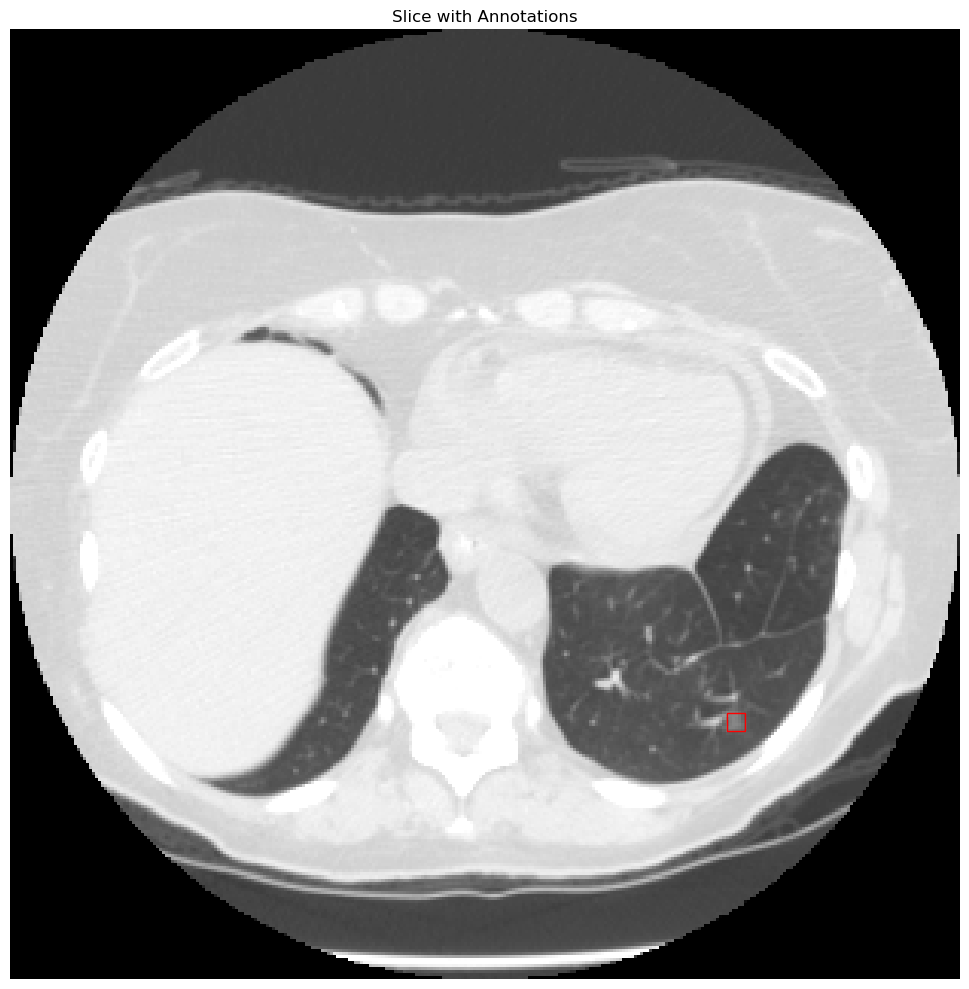

In [10]:
def show_slice_with_bboxes(slice_folder: str, series_uid: str):
    slice_file = np.load(os.path.join(os.getcwd(),"processed_data","processed_slices", slice_folder, series_uid, "slices.npz"))
    json_file = os.path.join(os.getcwd(),"processed_data","processed_slices", slice_folder, series_uid, "annotations.json")

    slice_key = None
    slice_filename = None

    bboxes = []

    try:
        with open(json_file) as f:
            annotations = json.load(f)

            # Get the non empty slice key from the json file
            for key in annotations.keys():
                if len(annotations[key]) > 0:
                    slice_key = key
                    slice_filename = key.split(".")[0] # Get the slice filename without the .npy extension
                    bboxes = annotations[key]

                    break

        if slice_key is None:
            print("Error: No annotations found in JSON file")
            return
    except FileNotFoundError:
        print("Error: JSON file not found")
        return
    except Exception as e:
        print(f"Error: {e}")
        return

    slice = slice_file[slice_filename]

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(slice, cmap='gray', origin='upper')

    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.title("Slice with Annotations")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

show_slice_with_bboxes("LUNA_02075", "1.3.6.1.4.1.14519.5.2.1.6279.6001.113679818447732724990336702075")

In [5]:
# Check the number of files in the LIDC-IDRI and LUNA16 datasets
print("LIDC files: ", len(lidc_dict))
print("LUNA files: ", len(luna_dict))

LIDC files:  1018
LUNA files:  888


In [7]:
diff_files = set(lidc_dict.keys()).difference(set(luna_dict.keys()))
print("Difference files: ", len(diff_files))
for file in diff_files:
    print(file)

Difference files:  130
1.3.6.1.4.1.14519.5.2.1.6279.6001.316643107252485100789257057503
1.3.6.1.4.1.14519.5.2.1.6279.6001.266485463235825902797310439568
1.3.6.1.4.1.14519.5.2.1.6279.6001.145580766024236783540879444879
1.3.6.1.4.1.14519.5.2.1.6279.6001.224845111941302943990256315343
1.3.6.1.4.1.14519.5.2.1.6279.6001.120301525825493211649827266081
1.3.6.1.4.1.14519.5.2.1.6279.6001.235381170872316280538332229850
1.3.6.1.4.1.14519.5.2.1.6279.6001.205113715251629496479289015582
1.3.6.1.4.1.14519.5.2.1.6279.6001.228049788831266512062175089637
1.3.6.1.4.1.14519.5.2.1.6279.6001.295958572786158575287945391206
1.3.6.1.4.1.14519.5.2.1.6279.6001.140642535005388188316143069436
1.3.6.1.4.1.14519.5.2.1.6279.6001.175773779529863791864938329989
1.3.6.1.4.1.14519.5.2.1.6279.6001.331136451298749863730308327406
1.3.6.1.4.1.14519.5.2.1.6279.6001.258063830035095530590787548770
1.3.6.1.4.1.14519.5.2.1.6279.6001.274231544628870369798516818358
1.3.6.1.4.1.14519.5.2.1.6279.6001.281254424459536762125243157973
1.

In [44]:
not_lidc = set(luna_dict.keys()).difference(set(lidc_dict.keys()))

print("Not LIDC files: ", not_lidc)

Not LIDC files:  {'1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002460665752357657094'}


In [2]:
dicom_path = os.path.join(os.getcwd(), "LIDC-IDRI", "manifest-1743272998332",
                          "LIDC-IDRI", "LIDC-IDRI-0001",
                          "01-01-2000-NA-NA-30178", "3000566.000000-NA-03192")

dicom_folders = os.listdir(dicom_path)

reader = sitk.ImageSeriesReader()
reader.SetImageIO("GDCMImageIO")

dicom_names = reader.GetGDCMSeriesFileNames(dicom_path)

reader.SetFileNames(dicom_names)

image = reader.Execute()

resampled_image = resample(image, (1.0, 1.0, 1.0))
windowed_image = apply_windowing(resampled_image, -600, 1500)
normalized_image = normalize(windowed_image)

# Extract the axial slices
num_slices = normalized_image.shape[0]
extract_axial_slices(normalized_image, num_slices)

size = image.GetSize()
print("Image size: ", size[0], size[1], size[2])

sitk.WriteImage(image, os.getcwd() + r'image.nii.gz')

if "SITK_NOSHOW" not in os.environ:
    sitk.Show(image, "Image")

Image size:  512 512 133


In [3]:
mhd_path = r"C:\Users\peter\Masters\Project\LUNA16\subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd"

image = sitk.ReadImage(mhd_path)

print("Image size: ", image.GetSize()[0], image.GetSize()[1], image.GetSize()[2])
print("Image spacing: ", image.GetSpacing()[0], image.GetSpacing()[1], image.GetSpacing()[2])

sitk.Show(image, "MHD Image")

Image size:  512 512 121
Image spacing:  0.7617189884185791 0.7617189884185791 2.5


In [4]:
get_dicom_folders_LIDC(os.path.join(os.getcwd(), "LIDC-IDRI", "manifest-1743272998332",
                          "LIDC-IDRI"))

{'1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192': 'C:\\Users\\peter\\Masters\\Project\\LIDC-IDRI\\manifest-1743272998332\\LIDC-IDRI\\LIDC-IDRI-0001\\01-01-2000-NA-NA-30178\\3000566.000000-NA-03192',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919': 'C:\\Users\\peter\\Masters\\Project\\LIDC-IDRI\\manifest-1743272998332\\LIDC-IDRI\\LIDC-IDRI-0002\\01-01-2000-NA-NA-98329\\3000522.000000-NA-04919',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264': 'C:\\Users\\peter\\Masters\\Project\\LIDC-IDRI\\manifest-1743272998332\\LIDC-IDRI\\LIDC-IDRI-0003\\01-01-2000-NA-NA-94866\\3000611.000000-NA-03264',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228': 'C:\\Users\\peter\\Masters\\Project\\LIDC-IDRI\\manifest-1743272998332\\LIDC-IDRI\\LIDC-IDRI-0004\\01-01-2000-NA-NA-91780\\3000534.000000-NA-58228',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225': 'C:\\Users\\peter\\Masters\\Project\\LIDC-IDRI\\manifest-17